# Интеллектуальный анализ данных – весна 2024

# Домашнее задание 7: Деревья. Случайный лес

## Мосалев Максим ИАД-7

Правила:

- Домашнее задание оценивается в 10 баллов (+1 бонусный балл).


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

<!-- ![](meme.jpg) -->
<img src="meme.jpg" alt="Drawing" style="width: 700px;"/>

## Часть 1: Основы построения решающие дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [2]:
pi = np.array([8/10, 2/10]) # Вероятности классов
entropy = -np.sum(pi * np.log(pi)) # Рассчет энтропии
print("Энтропия распределения классов: {:.2f}".format(entropy))

Энтропия распределения классов: 0.50


**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [56]:
# Вычисление индекса Джини
def gini_index(labels):
    total_samples = len(labels)
    classes = np.unique(labels)
    gini = 0
    for cls in classes:
        p = np.sum([labels[i] == cls for i in range(len(labels))]) / total_samples
        gini += p * (1 - p)
    return gini

p_left = 8 / 10
p_right = 2 / 10

# Вычисление критерия информативности
Q = gini_index(['k1'] * 8 + ['k2'] * 2) - p_left * gini_index(['k1'] * 8) - p_right * gini_index(['k2'] * 2)

print("Функционал качества: {:.2f}".format(Q))

Функционал качества: 0.32


**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [5]:
target_values = [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] # Значения целевой переменной для объектов в листовой вершине

pred = sum(target_values) / len(target_values)

print("Предсказание модели: {:.2f}".format(pred))

Предсказание модели: 40.60


## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [2]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

In [5]:
from typing import Union, Tuple
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame], 
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`
    
    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия информативности для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """
    # Сортируем значения признака
    sorted_indices = np.argsort(feature_vector)
    sorted_features = feature_vector[sorted_indices]
    sorted_targets = target_vector[sorted_indices]
    
    # Находим уникальные значения признака и их позиции в отсортированном массиве
    unique_values, value_indices = np.unique(sorted_features, return_index=True)
    
    # пороги - среднее двух сосдених значений признака #без цикла:)
    thresholds = (unique_values[:-1] + unique_values[1:]) / 2  
    
    # Вычисляем критерий информативности для левых и правых подвыборок
    left_sizes = value_indices[1:]  # Размеры левых подвыборок
    right_sizes = len(sorted_features) - left_sizes  # Размеры правых подвыборок
    left_targets = [sorted_targets[:i] for i in left_sizes]  # Целевые переменные для левых подвыборок
    right_targets = [sorted_targets[i:] for i in left_sizes]  # Целевые переменные для правых подвыборок
    
    if task == "regression":
        left_criterions = [np.var(i) for i in left_targets]
        right_criterions = [np.var(i) for i in right_targets]
        prev_criterion = np.var(sorted_targets)
    elif task == "classification":
        left_criterions = [gini_index(i) for i in left_targets]
        right_criterions = [gini_index(i) for i in right_targets]
        prev_criterion = gini_index(sorted_targets)
    
    # Вычисляем критерий информативности для каждого порога
    criterions = np.array(prev_criterion) - (np.array(left_sizes) / len(sorted_features)) * left_criterions - \
                        (np.array(right_sizes) / len(sorted_features)) * right_criterions
    threshold_best = 0
    criterion_best = 0
    # Находим оптимальное разбиение
    if criterions.size > 0:
        best_index = np.argmax(criterions)
        threshold_best = thresholds[best_index]
        criterion_best = criterions[best_index]
    return thresholds, criterions, threshold_best, criterion_best

# Функция для вычисления критерия Джини
def gini_index(labels):
    labels = np.array(labels)
    total_samples = len(labels)
    classes = np.unique(labels)
    gini = 0
    for cls in classes:
        p = np.sum([labels[i] == cls for i in range(len(labels))]) / total_samples
        gini += p * (1 - p)
    return gini

Эту функцию можно протестировать на датасете `California`.

In [6]:
from sklearn.datasets import fetch_california_housing

In [5]:
data = fetch_california_housing()
X = pd.DataFrame(data=data["data"], columns=data["feature_names"])
y = data["target"]
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [25]:
y

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `MedInc`.

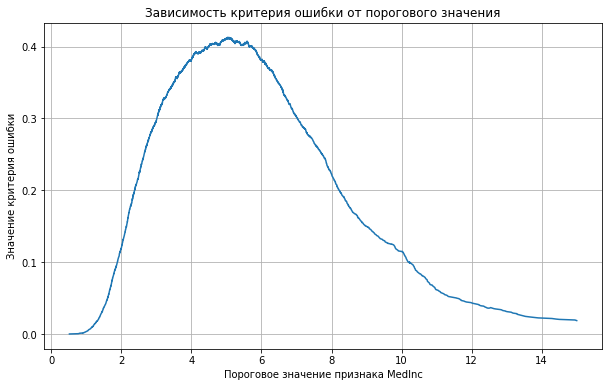

In [6]:
# Функция для вычисления критерия информативности по признаку MedInc
thresholds, criterions, best_t, best_kr = find_best_split(X['MedInc'].values, y, task='regression')

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(thresholds, criterions)
plt.title('Зависимость критерия информативности от порогового значения')
plt.xlabel('Пороговое значение признака MedInc')
plt.ylabel('Значение критерия ошибки')
plt.grid(True)
plt.show()

Найдите лучший, с вашей точки зрения, предикат первой вершины решающего дерева.

In [7]:
print(f'Лучший порог для признака MedINc: {best_t}')

Лучший порог для признака MedINc: 5.03515


**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

В задаче также предлагается получить два бонуса, по баллу на каждый!

- **Реализуйте способ обрабатывать пропуски в даннх и реализуйте его, пояснив свои действия.**
- **Реализуйте метод оценки важности признаков.**

In [7]:
class DecisionTree:
    
    def __init__(
        self, 
        feature_types: Union[List[str], np.ndarray], 
        max_depth: int = None, 
        min_samples_split: int = None, 
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:
        
        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}
        
        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types
        
        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task
        
        # Переменная, если вы решите делать бонус
        self._feature_importances = {}
        

    def _fit_node(
        self, 
        sub_X: np.ndarray, 
        sub_y: np.ndarray, 
        node: dict
    ) -> None:
        
        # критерий останова
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            # подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                # здесь могла быть реализация более сложного подхода к обработке категориального признака
                feature_vector = sub_X[:, feature]

            # ищем оптимальный порог
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)
            
            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini

                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    split = feature_vector <= threshold_best
                elif feature_type == "categorical":
                    # в данной реализации это просто значение категории
                    threshold_best = threshold
                    split = feature_vector == threshold_best
                else:
                    raise ValueError

        # записываем полученные сплиты в атрибуты класса
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError
            
        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        if node["type"] == "terminal":
            return node["class"]
    
        feature_split = node["feature_split"]
        if self._feature_types[feature_split] == "real":
            if x[feature_split] <= node["threshold"]:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])
        elif self._feature_types[feature_split] == "categorical":
            if x[feature_split] == node["category_split"]:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)
        
    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))
            
        return np.array(predicted)
        
    def _calculate_feature_importance(self, node: dict, importance: dict) -> None:
        """
        Рекурсивно вычисляет важность признаков для каждого узла дерева.
        :param node: dict, вершина дерева
        :param importance: dict, словарь для хранения важности признаков
        """
        feature_split = node["feature_split"]
        if feature_split not in importance:
            importance[feature_split] = 0
        importance[feature_split] += 1

        self._calculate_feature_importance(node["left_child"], importance)
        self._calculate_feature_importance(node["right_child"], importance)

    def calculate_feature_importance(self) -> dict:
        """
        Вычисляет важность признаков для решающего дерева.
        :return: dict, словарь, в котором ключи - индексы признаков, значения - их важность
        """
        importance = {}
        self._calculate_feature_importance(self._tree, importance)
        return importance
    
    def fill_missing_values(self, X: np.ndarray) -> np.ndarray:
        """
        Заполнение пропусков в данных
        :param X: np.array, матрица объекты-признаки
        """
        filled_X = X.copy()
        for feature_idx in range(X.shape[1]):
            feature_type = self._feature_types[feature_idx]
            feature_values = X[:, feature_idx]
            nan_mask = np.isnan(feature_values)

            if feature_type == "real":
                # Заполняем пропущенные значения средним значением по признаку
                mean_value = np.nanmean(feature_values)
                filled_X[nan_mask, feature_idx] = mean_value
            elif feature_type == "categorical":
                # Заполняем пропущенные значения самой частой категорией
                mode_value = np.argmax(np.bincount(feature_values[~nan_mask]))
                filled_X[nan_mask, feature_idx] = mode_value
            else:
                raise ValueError("Unknown feature type")

        return filled_X

**Задание 2.3 (1 балл)** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

In [33]:
df = pd.read_csv('students.csv')
df = df.drop(columns=['Unnamed: 0']) # удалим не нужный столбец нумерации данных
X = df.drop(columns=['UNS'])
y = df['UNS']
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (258, 6)


,STG,SCG,STR,LPR,PEG,UNS
0,0.00,0.00,0.00,0.00,0.00,0
1,0.08,0.08,0.10,0.24,0.90,1
2,0.06,0.06,0.05,0.25,0.33,0
3,0.10,0.10,0.15,0.65,0.30,1
4,0.08,0.08,0.08,0.98,0.24,0


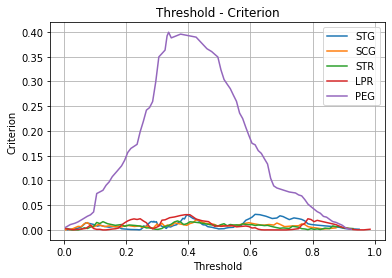

In [30]:
for feature in X.columns:
    # Вычисление критериев Джини для каждого порога
    thresholds, criterions, _, _ = find_best_split(X[feature], y, task='classification')
    
    # Построение кривой "порог — значение критерия Джини"
    plt.plot(thresholds, criterions, label=feature)

# Добавление подписей и легенды
plt.title('Threshold - Criterion')
plt.xlabel('Threshold')
plt.ylabel('Criterion')
plt.legend()
plt.grid(True)
plt.show()

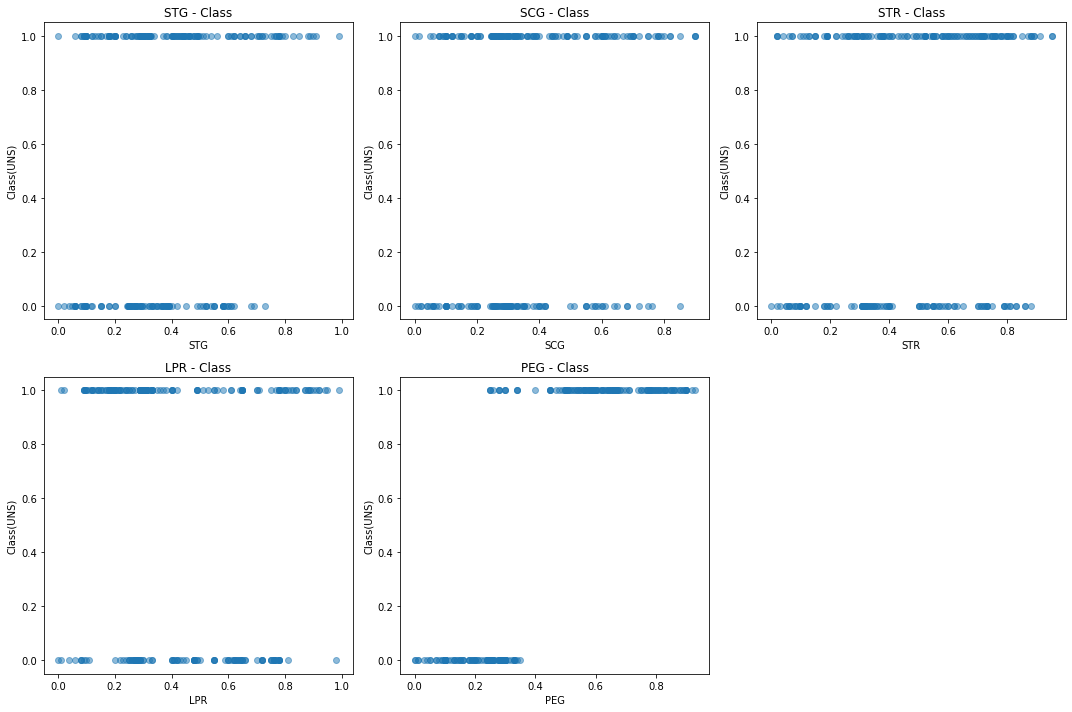

In [34]:
plt.figure(figsize=(15, 10))
for i, column in enumerate(df.columns[:-1]):
    plt.subplot(2, 3, i+1)
    plt.scatter(df[column], df['UNS'], alpha=0.5)
    plt.xlabel(column)
    plt.ylabel('Class(UNS)')
    plt.title(f'{column} - Class')
plt.tight_layout()
plt.show()

Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

**Ответ:** Исходя из кривых значений критерия Джини, нужно производить деление выборки на два поддерева по признаку PEG.  
Этот результат согласуется с визуальной оценкой диаграмм рассеяиния, потому что как раз для признака PEG (и только для него) отчетливо виден предикат, чтобы раззличить два класса (примерно 0.4).   
Для "хороших" признаков, по которым выборка делится почти идеально, кривая имеет отчетливый максимум, сначала стремительно растет, а затем падает, то есть имеет вид близкий к параболе ветвями вниз.   
Кривые для признаков, по которым деление практически невозможно, не имеют отчетливых максимумов, пологие и близки к нулю.

**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom). 

1. Скачайте таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)), 
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа. 

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data"
columns = ["class", "cap-shape", "cap-surface", "cap-color", "bruises", "odor", "gill-attachment",
           "gill-spacing", "gill-size", "gill-color", "stalk-shape", "stalk-root",
           "stalk-surface-above-ring", "stalk-surface-below-ring", "stalk-color-above-ring",
           "stalk-color-below-ring", "veil-type", "veil-color", "ring-number", "ring-type",
           "spore-print-color", "population", "habitat"]
data = pd.read_csv(url, header=None, names=columns)

# Применение LabelEncoder к каждому столбцу
label_encoder = LabelEncoder()
for column in data.columns:
    data[column] = label_encoder.fit_transform(data[column])

# Разделение данных на обучающий и тестовый наборы
X = data.drop('class', axis=1)
y = data['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

tree = DecisionTree(
    feature_types=["categorical"] * len(columns[1:]),
    max_depth=5,
    min_samples_split=2,
    min_samples_leaf=1,
    task="classification"
)
tree.fit(np.array(X_train), np.array(y_train))

# Предсказания для тестового набора
y_pred = tree.predict(X_test)

# Вычисление accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy на тестовом наборе данных:", accuracy)

## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [2]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [3]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

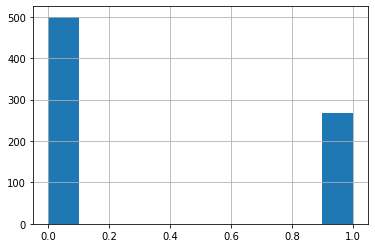

In [9]:
data['Outcome'].hist()
plt.show()

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [4]:
X = data.drop(columns=['Outcome']) 
y = data['Outcome']                 

# Разбиение датасета на обучающую и тестовую выборки
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Разбиение обучающей выборки на обучающую-обучающую и обучающую-валидационную
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.3, random_state=42)

# Вывод размеров полученных выборок
print(f"Размер обучающей-обучающей выборки: {X_train.shape}")
print(f"Размер обучающей-валидационной выборки: {X_val.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

Размер обучающей-обучающей выборки: (375, 8)
Размер обучающей-валидационной выборки: (162, 8)
Размер тестовой выборки: (231, 8)


**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке. 


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV

# Создание списков с возможными значениями для перебора
param_grid = {
    'max_depth': [3, 5, 7, 9, 10, 20, 30, 100, 300],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 10, 15]
}

# Создание экземпляра классификатора
dt_clf = DecisionTreeClassifier(random_state=42)

# Поиск оптимальных гиперпараметров с помощью GridSearchCV
grid_search = GridSearchCV(dt_clf, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)

# Вывод наилучших параметров
print("Наилучшие параметры:", grid_search.best_params_)

# Обучение решающего дерева с наилучшими параметрами на полной обучающей выборке
best_dt_clf = grid_search.best_estimator_
best_dt_clf.fit(X_train_full, y_train_full)

# Оценка качества на тестовой выборке
y_pred = best_dt_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred)

print("Метрики на тестовой выборке:")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"AUC-ROC: {auc_roc}")

Наилучшие параметры: {'max_depth': 10, 'min_samples_leaf': 5}
Метрики на тестовой выборке:
Accuracy: 0.7229437229437229
Precision: 0.5930232558139535
Recall: 0.6375
AUC-ROC: 0.7028559602649007


**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [12]:
# Создание BaggingClassifier с 50 деревьями
bagging_clf = BaggingClassifier(n_estimators=50, random_state=42)

# Обучение модели на полной обучающей выборке
bagging_clf.fit(X_train_full, y_train_full)

# Оценка качества на тестовой выборке
y_pred_bagging = bagging_clf.predict(X_test)
accuracy_bagging = accuracy_score(y_test, y_pred_bagging)
precision_bagging = precision_score(y_test, y_pred_bagging)
recall_bagging = recall_score(y_test, y_pred_bagging)
auc_roc_bagging = roc_auc_score(y_test, y_pred_bagging)

print("Метрики на тестовой выборке для BaggingClassifier:")
print(f"Accuracy: {accuracy_bagging}")
print(f"Precision: {precision_bagging}")
print(f"Recall: {recall_bagging}")
print(f"AUC-ROC: {auc_roc_bagging}")

Метрики на тестовой выборке для BaggingClassifier:
Accuracy: 0.7489177489177489
Precision: 0.6309523809523809
Recall: 0.6625
AUC-ROC: 0.7286009933774835


**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации. 
3. Выберите ту пару значений, которая даёт наилучшее среднее качество. 

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Создание списков с возможными значениями для перебора
param_grid = {
    'max_depth': [5, 10, 15, 20, 30, 40, 50, 100],
    'min_samples_split': [2, 5, 10, 15, 20]
}

# Создание экземпляра RandomForestClassifier с 50 деревьями
rf_clf = RandomForestClassifier(n_estimators=50, random_state=42)

# Поиск оптимальных гиперпараметров с помощью GridSearchCV
grid_search_rf = GridSearchCV(rf_clf, param_grid, cv=5, scoring='f1')
grid_search_rf.fit(X_train_full, y_train_full)

# Вывод наилучших параметров
print("Наилучшие параметры:", grid_search_rf.best_params_)

# Обучение случайного леса с подобранными параметрами на полной обучающей выборке
best_rf_clf = grid_search_rf.best_estimator_
best_rf_clf.fit(X_train_full, y_train_full)

# Оценка качества на тестовой выборке
y_pred_rf = best_rf_clf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
auc_roc_rf = roc_auc_score(y_test, y_pred_rf)

print("Метрики на тестовой выборке для Random Forest:")
print(f"Accuracy: {accuracy_rf}")
print(f"Precision: {precision_rf}")
print(f"Recall: {recall_rf}")
print(f"AUC-ROC: {auc_roc_rf}")

Наилучшие параметры: {'max_depth': 10, 'min_samples_split': 15}
Метрики на тестовой выборке для Random Forest:
Accuracy: 0.7532467532467533
Precision: 0.6455696202531646
Recall: 0.6375
AUC-ROC: 0.7260347682119205


Бэггинг и случайный лес определенно лучше решающего дерева. Случайный лес при данных параметрах лучше бэггинга по accuracy и precision, чуть хуже по Recall и почти такой же AUC-ROC. При данных параметрах скорее Random Forest проявил себя лучше. 

**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

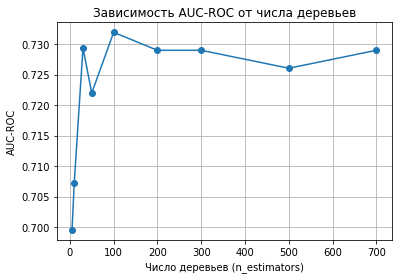

In [31]:
import matplotlib.pyplot as plt

n_estimators_values = [5, 10, 30, 50, 100, 200, 300, 500, 700] # Значения для числа деревьев

auc_roc_values = [] # Список для хранения значений AUC-ROC

# Обучение случайного леса с разным числом деревьев и оценка его производительности на тестовой выборке
for n_estimators in n_estimators_values:
    rf_clf = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    rf_clf.fit(X_train_full, y_train_full)
    y_pred_rf = rf_clf.predict(X_test)
    auc_roc = roc_auc_score(y_test, y_pred_rf)
    auc_roc_values.append(auc_roc)

# Построение графика
plt.plot(n_estimators_values, auc_roc_values, marker='o')
plt.title('Зависимость AUC-ROC от числа деревьев')
plt.xlabel('Число деревьев (n_estimators)')
plt.ylabel('AUC-ROC')
plt.grid(True)
plt.show()

Для случайного леса важно количество деревьев. Чем больше деревьев, тем лучше качество. На обучающей выборке при увеличении количества деревьев качестов будет улучшаться, а на тестовой выборке при увеличении кол-ва деревьев в некоторый момент качество выходит на асимптоту.

**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

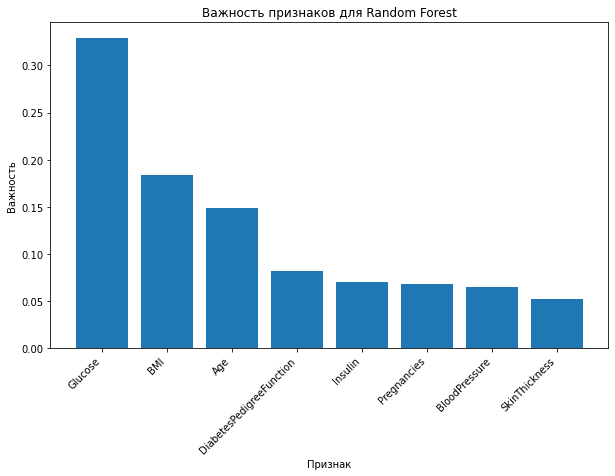

Самый важный признак для определения диабета: Glucose


In [15]:
# Получение важности признаков из лучшей модели случайного леса
feature_importances = best_rf_clf.feature_importances_

# Создание DataFrame для удобства визуализации
importance_df = pd.DataFrame({'Feature': X_train_full.columns, 'Importance': feature_importances})

# Сортировка значений по важности
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Построение bar plot
plt.figure(figsize=(10, 6))
plt.bar(importance_df['Feature'], importance_df['Importance'])
plt.title('Важность признаков для Random Forest')
plt.xlabel('Признак')
plt.ylabel('Важность')
plt.xticks(rotation=45, ha='right')
plt.show()

# Получение самого важного признака
most_important_feature = importance_df.iloc[0]['Feature']
print(f"Самый важный признак для определения диабета: {most_important_feature}")

Получили, что самый важный признак для определения диабета это уровень глюкозы (Glucose), что и логично.